In [2]:
# sudo apt-get update
# sudo apt-get install graphviz graphviz-dev


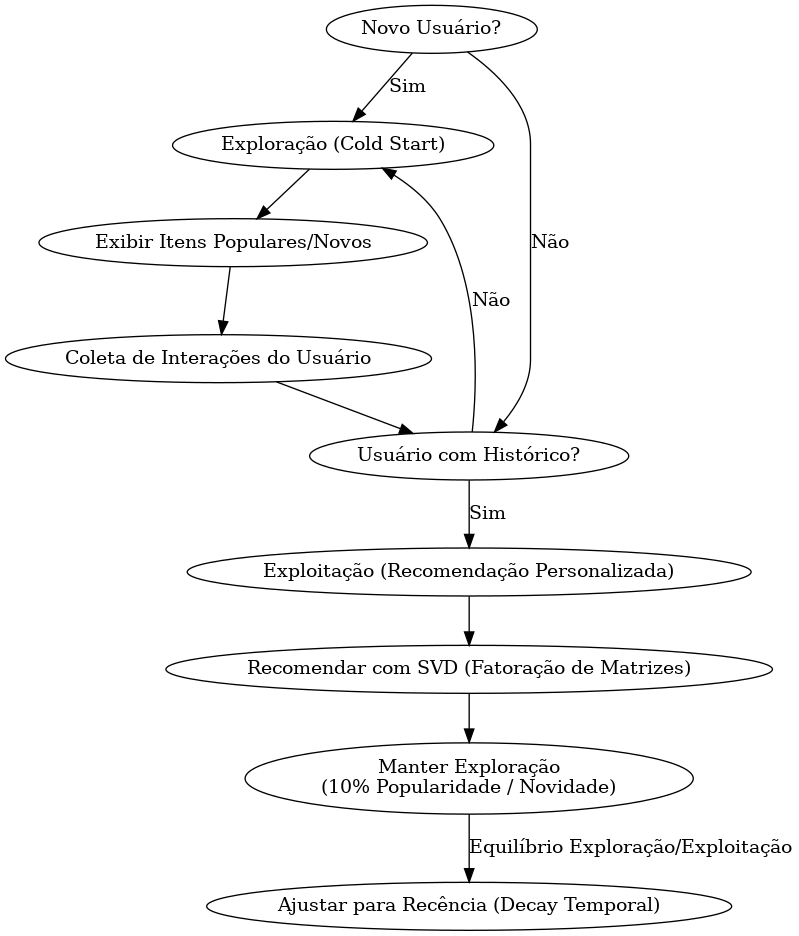

In [3]:
from IPython.display import Image, display
from graphviz import Digraph

# Criando o diagrama de decisão para recomendação com Cold Start e Recência
dot = Digraph(comment='Sistema de Recomendação: Exploração vs. Exploitação', format='png')

# Nós principais
dot.node('A', 'Novo Usuário?')
dot.node('B', 'Exploração (Cold Start)')
dot.node('C', 'Exibir Itens Populares/Novos')
dot.node('D', 'Coleta de Interações do Usuário')
dot.node('E', 'Usuário com Histórico?')
dot.node('F', 'Exploitação (Recomendação Personalizada)')
dot.node('G', 'Recomendar com SVD (Fatoração de Matrizes)')
dot.node('H', 'Manter Exploração\n(10% Popularidade / Novidade)')
dot.node('I', 'Ajustar para Recência (Decay Temporal)')

# Conexões
dot.edge('A', 'B', label='Sim')
dot.edge('A', 'E', label='Não')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F', label='Sim')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I', label='Equilíbrio Exploração/Exploitação')
dot.edge('E', 'B', label='Não')

display(Image(dot.pipe(format='png')))

A recência é um componente do cálculo do RFV (Recência, Frequência e Valor), uma métrica de vendas que ajuda empresas a identificar os seus clientes mais importantes.
Como calcular a recência?
Calcula-se quantos dias se passaram desde a última compra do cliente

In [24]:
import pandas as pd
import glob

In [43]:
user_infos = pd.concat([pd.read_csv(fpath) for fpath in glob.glob('../data/files/treino/*.csv')])
user_infos.head()

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
0,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,Logged,12,"50028008-aa11-4519-9d75-452c84dd27fb, d031af1b...","1657264136826, 1657552410329, 1657552529759, 1...","4, 41, 6, 0, 0, 1, 1, 1, 21, 79, 25, 1","10081, 70000, 12216, 90000, 161291, 346113, 77...","16.34, 79.35, 13.36, 37.95, 73.83, 68.98, 51.6...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1","1657264136826, 1657552410329, 1657552529759, 1..."
1,3a3b7f25a30a5a17a530685545e3a0be38cee0c6904c42...,Logged,93,"561850c2-9ade-4985-bf36-402abf02153d, c4ab5277...","1656683068549, 1656692064526, 1656696714488, 1...","6, 9, 19, 20, 14, 9, 13, 21, 9, 20, 50, 16, 1,...","28139, 70000, 230000, 120000, 78858, 50000, 30...","21.82, 51.35, 93.4, 81.35, 78.47, 37.43, 27.39...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","1656683068549, 1656692064526, 1656696714488, 1..."
2,ea6728ebc30782516a7593a1143c47dc59428e1649c048...,Logged,8,"c7505bef-22eb-49e3-bbde-43281d36981e, 9a7695fe...","1657834002471, 1657834031446, 1657895788959, 1...","0, 0, 3, 2, 223, 29, 8, 13","10000, 70000, 10928, 10112, 1481132, 165124, 3...","8.21, 81.2, 24.18, 16.33, 81.15, 44.95, 16.09,...","1, 1, 1, 1, 1, 1, 2, 1","1657834002471, 1657834031446, 1657895788959, 1..."
3,f909c50558c01ab790636e1b1918e6a5965bdcc271a860...,Non-Logged,19,"598ed114-fd5a-4d82-90d8-f1e893cb0892, 92165aa2...","1656872519048, 1656895522162, 1656952360252, 1...","0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0...","30007, 43153, 41626, 39675, 12100, 40000, 4888...","12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","1656872519048, 1656895522162, 1656952360252, 1..."
4,9725352f759a73aa977cb5eff2596a5f683fcd0c753200...,Logged,34,"80753b6f-d65c-4962-9f2e-ef582cce0de0, 97593626...","1656762806361, 1656764327095, 1656782770362, 1...","6, 16, 0, 0, 0, 6, 1, 1, 0, 0, 0, 0, 0, 3, 1, ...","100000, 110000, 50000, 6455, 68291, 60000, 100...","49.25, 66.86, 71.52, 17.58, 59.33, 37.27, 14.7...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1...","1656762806361, 1656764327095, 1656782770362, 1..."


In [45]:
user_infos.query('history == "d2593c3d-2347-40d9-948c-b6065e8459a9"').groupby('userId')[['pageVisitsCountHistory']].max().sort_values(by='pageVisitsCountHistory',ascending=False).head()

user_infos.query('userId == "322b58021386f93bac956ad675771fde1b16d8bd9f76b2cf80e65dab3876c91e"')

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
74150,322b58021386f93bac956ad675771fde1b16d8bd9f76b2...,Non-Logged,1,d2593c3d-2347-40d9-948c-b6065e8459a9,1657583760078,84,231533,22.57,6,1657583760078


In [31]:
user_historys = user_infos[['userId', 'history','timestampHistory','numberOfClicksHistory','timeOnPageHistory','scrollPercentageHistory','pageVisitsCountHistory','timestampHistory_new']]
# user_infos.drop(columns=['history','timestampHistory','numberOfClicksHistory','timeOnPageHistory','scrollPercentageHistory','pageVisitsCountHistory','timestampHistory_new'], inplace=True)
# user_infos.set_index('userId', inplace=True)


user_historys = user_historys.set_index('userId').apply(lambda row: row.str.split(','), axis=1)
user_historys = user_historys.apply(pd.Series.explode).reset_index()
user_historys['numberOfClicksHistory'] = user_historys['numberOfClicksHistory'].astype(int)
user_historys['timeOnPageHistory'] = user_historys['timeOnPageHistory'].astype(int)
user_historys['scrollPercentageHistory'] = user_historys['scrollPercentageHistory'].astype(float)
user_historys['timestampHistory'] = user_historys['timestampHistory'].astype(int)
user_historys['pageVisitsCountHistory'] = user_historys['pageVisitsCountHistory'].astype(int)

user_historys.head()

,userId,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
0,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,50028008-aa11-4519-9d75-452c84dd27fb,1657264136826,4,10081,16.34,1,1657264136826
1,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,d031af1b-f939-47c1-a589-e6d691b66d91,1657552410329,41,70000,79.35,1,1657552410329
2,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,bf257382-74fb-4392-ad6a-143240e39f81,1657552529759,6,12216,13.36,1,1657552529759
3,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,66a9efac-fd43-4fd1-9824-c404b08efa5d,1657632476730,0,90000,37.95,1,1657632476730
4,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,7a349b09-badc-40a9-a194-83d959aeb50c,1657632495643,0,161291,73.83,1,1657632495643


In [32]:
news_item = pd.concat([pd.read_csv(fpath) for fpath in glob.glob('../data/itens/itens/*.csv')])
news_item.head()

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic..."


# Premeira tentativa de recomendação heurística

In [33]:
from datetime import datetime
import numpy as np
import pandas as pd



def calc_recency_score(issued: pd.Series) -> pd.Series:
    """
    Calcula o score de recência para uma série de timestamps.
    
    O score é inversamente proporcional ao tempo decorrido, 
    dando mais prioridade a notícias mais recentes.
    
    :param issued: Série com os timestamps das notícias.
    :return: Série com os scores de recência.
    """
    # Converter os timestamps para milissegundos

    now = parse_date_timestamp(datetime.timestamp(datetime.now()))
    # Calcular o score de recência, evitando divisão por zero
    return 1 / np.maximum(now - parse_date_timestamp(issued), 1e-6)



def parse_date_timestamp(date):
    # Converte para datetime se ainda for string
   if isinstance(date, str):
    date = pd.to_datetime(date, errors='coerce')
   elif isinstance(date, float):
      return (date * 1000)

   return int(datetime.timestamp(date) * 1000)


def history_by(userId: str):
    return user_historys.query('userId == @userId').set_index('history')



user_history = history_by('e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d5092adc513f516b377')
user_history.head()




#user_infos.set_index('userId').loc['e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d5092adc513f516b377'].head()

,userId,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
history,,,,,,,
50028008-aa11-4519-9d75-452c84dd27fb,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,1657264136826,4,10081,16.34,1,1657264136826
d031af1b-f939-47c1-a589-e6d691b66d91,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,1657552410329,41,70000,79.35,1,1657552410329
bf257382-74fb-4392-ad6a-143240e39f81,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,1657552529759,6,12216,13.36,1,1657552529759
66a9efac-fd43-4fd1-9824-c404b08efa5d,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,1657632476730,0,90000,37.95,1,1657632476730
7a349b09-badc-40a9-a194-83d959aeb50c,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,1657632495643,0,161291,73.83,1,1657632495643


In [34]:
news_item['recency_score'] = news_item['issued'].apply(calc_recency_score)
news_item = news_item.sort_values('recency_score', ascending=False)

In [47]:
temp = (
    user_historys
    .groupby('history')['pageVisitsCountHistory']
    .sum()
    .sort_values(ascending=False)
    .head(2000)
)

print(temp)


history
esid:conteudo_editorial_g1#materia#https://especiais.g1.globo.com/bemestar/coronavirus/estados-brasil-mortes-casos-media-movel/                    14076
esid:conteudo_editorial_g1#materia#https://especiais.g1.globo.com/bemestar/coronavirus/2021/mapa-cidades-brasil-mortes-covid/                       5468
esid:conteudo_editorial_g1#materia#https://especiais.g1.globo.com/bemestar/vacina/2021/mapa-brasil-vacina-covid/                                    2748
 abb7e929-e720-4b00-b4bb-dcd8c408659c                                                                                                               1113
 esid:conteudo_editorial_g1#materia#https://especiais.g1.globo.com/economia/concursos-e-emprego/lista-de-concursos-publicos-e-vagas-de-emprego/     1036
                                                                                                                                                   ...  
 6b3e8cfc-d40a-4dc1-bf3f-9a4ff3e5b4ba                                     

In [20]:
def recomendacao_por_popularidade():

    leu_meia_pagina = user_historys.query('scrollPercentageHistory > 0.5')[['userId','history']]

    return (leu_meia_pagina
     .groupby(['history'])[['userId']]
     .count()
     .sort_values(by=['userId'], ascending=False))

recomendacao_por_popularidade()


,userId
history,
d2593c3d-2347-40d9-948c-b6065e8459a9,24343
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd,21803
1f32787b-de2b-49be-8c20-ddaeae34cc22,18328
f0a78e58-ec7e-494c-9462-fbd6446a9a89,17954
6a83890a-d9e9-4f6b-a6c6-90d031785bbf,17811
...,...
ffe6adda-83cf-4813-9a46-d0f54cb7d9b0,1
ffe68a4b-bdb1-4aed-888a-af12992fbe9d,1
ffe67bdb-2495-43b5-b760-8f4c9554fb09,1


In [17]:
news_item.set_index('page').loc['d2593c3d-2347-40d9-948c-b6065e8459a9'].head()

url         http://g1.globo.com/rj/rio-de-janeiro/noticia/...
issued                              2022-07-11 03:20:57+00:00
modified                            2022-07-12 23:06:28+00:00
title       Anestesista é preso em flagrante por estupro d...
body        Vídeo mostra momento em que anestesista estupr...
Name: d2593c3d-2347-40d9-948c-b6065e8459a9, dtype: object